In [2]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from transformers import BertModel,BertTokenizer
import numpy as np
import tqdm.notebook as tq
from sklearn.metrics import confusion_matrix,classification_report,f1_score


device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

df = pd.read_csv("C:/nlp_projects/news/bbc-text-1.csv",delimiter=',',nrows=20000)
df.head(10)

cuda


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [3]:

df.isnull().sum()
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df['category'].head(10)
df['category'].value_counts()
df['Text'] = df['text']
df.drop('text',inplace=True,axis=1)

df['sports'] = (df['category'] == "sport").astype(int)
df['business'] = (df['category'] == "business").astype(int)
df['politics'] = (df['category'] == "politics").astype(int)
df['entertainment'] = (df['category'] == "entertainment").astype(int)
df['tech'] = (df['category'] == "tech").astype(int)

df.drop("category",inplace=True,axis=1)


learning_rate = 1e-5
MAX_LEN = 256
EPOCHS = 4

MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)




class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self,df,labels,max_len,tokenizer):
        self.df = df
        self.Text = list(df['Text'])
        self.targets = self.df[labels].values
        self.max_len = max_len
        self.tokenizer=  tokenizer
        
        
    def __len__(self):
        return len(self.Text)
    
    
    def __getitem__(self, idx):
        Text = str(self.Text[idx])
        Text = " ".join(Text.split())
        
        encoder = self.tokenizer.encode_plus(
            Text,
            None,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            add_special_tokens=True,
            return_tensors='pt',
            )
        
        return {
            "Text":Text,
            "input_ids":encoder['input_ids'].flatten(),
            "attention_mask":encoder['attention_mask'].flatten(),
            "token_type_ids":encoder['token_type_ids'].flatten(),
            "targets":torch.FloatTensor(self.targets[idx])
            }


from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df,test_size=.20,random_state=42)
df_val,df_test = train_test_split(df_test,test_size=.50,random_state=42)


labels = list(df.columns)
labels = labels[1:]

train_dataset = Custom_Dataset(df_train,labels,max_len=MAX_LEN,tokenizer=tokenizer)
test_dataset = Custom_Dataset(df_test, labels, max_len=MAX_LEN, tokenizer=tokenizer)
val_dataset = Custom_Dataset(df_val, labels, max_len=MAX_LEN, tokenizer=tokenizer)

TRAIN_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4


train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=TRAIN_BATCH_SIZE,num_workers=0)
test_dataloader=  torch.utils.data.DataLoader(test_dataset,batch_size=TEST_BATCH_SIZE,num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=VAL_BATCH_SIZE,num_workers=0)

data = next(iter(train_dataloader))
data.keys()

dict_keys(['Text', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])

In [4]:

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained(MODEL_NAME, return_dict=True)
        self.dropout = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output


    

model = BertClassifier()
model.to(device)

BertClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [5]:
def loss_fn(outputs,targets):
    return nn.BCEWithLogitsLoss()(outputs,targets)



optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)



def train_model(train_dataloader, model, optimizer):
    model.train()
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.train()
    loop = tq.tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True)
    for batch_idx, data in loop:
        input_ids = data['input_ids'].to(device, dtype = torch.long)
        attention_mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)


        outputs = model(input_ids, attention_mask,token_type_ids)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        _, preds = torch.max(outputs, dim=1)
        _, targ = torch.max(targets, dim=1)
        num_samples += len(targ)
        correct_predictions += torch.sum(preds == targ)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


    return model, float(correct_predictions)/num_samples, np.mean(losses)



def eval_model(val_dataloader, model, optimizer):
    model.eval()
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(val_dataloader, 0):
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())


            _, preds = torch.max(outputs, dim=1)
            _, targ = torch.max(targets, dim=1)
            num_samples += len(targ)
            correct_predictions += torch.sum(preds == targ)

    return float(correct_predictions)/num_samples, np.mean(losses)






for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_dataloader, model, optimizer)
    val_acc, val_loss = eval_model(val_dataloader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.2f} train_acc={train_acc:.2f}, val_acc={val_acc:.4f}')

Epoch 1/4


  0%|          | 0/425 [00:00<?, ?it/s]

train_loss=0.2463, val_loss=0.07 train_acc=0.87, val_acc=0.9718
Epoch 2/4


  0%|          | 0/425 [00:00<?, ?it/s]

train_loss=0.0445, val_loss=0.05 train_acc=0.99, val_acc=0.9765
Epoch 3/4


  0%|          | 0/425 [00:00<?, ?it/s]

train_loss=0.0202, val_loss=0.05 train_acc=1.00, val_acc=0.9718
Epoch 4/4


  0%|          | 0/425 [00:00<?, ?it/s]

train_loss=0.0114, val_loss=0.04 train_acc=1.00, val_acc=0.9671


In [6]:
test_acc,test_loss = eval_model(test_dataloader, model, optimizer)
print(f'testing accuracy: {test_acc*100:.2f}%')
print(f'testing loss: {test_loss*100:.2f}')

testing accuracy: 96.71%
testing loss: 5.21


In [7]:
def get_predictions(model, dataloader):
    model.eval()
    
    Texts = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in dataloader:
        Text = data["Text"]
        input_ids = data["input_ids"].to(device, dtype = torch.long)
        attention_mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(input_ids, attention_mask, token_type_ids)
        _, preds = torch.max(outputs, dim=1)
        _, targ = torch.max(targets, dim=1)

        Texts.extend(Text)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targ)
        
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    target_values = torch.stack(target_values).cpu()
    
    return Texts, predictions, prediction_probs, target_values
     


Texts, predictions, prediction_probs, target_values = get_predictions(model, test_dataloader)


print(classification_report(predictions,target_values, target_names=labels))

print(f1_score(predictions, target_values,average='micro'))

               precision    recall  f1-score   support

       sports       1.00      1.00      1.00        49
     business       0.95      0.95      0.95        56
     politics       0.95      0.98      0.96        42
entertainment       1.00      0.97      0.98        30
         tech       0.94      0.94      0.94        36

     accuracy                           0.97       213
    macro avg       0.97      0.97      0.97       213
 weighted avg       0.97      0.97      0.97       213

0.9671361502347418


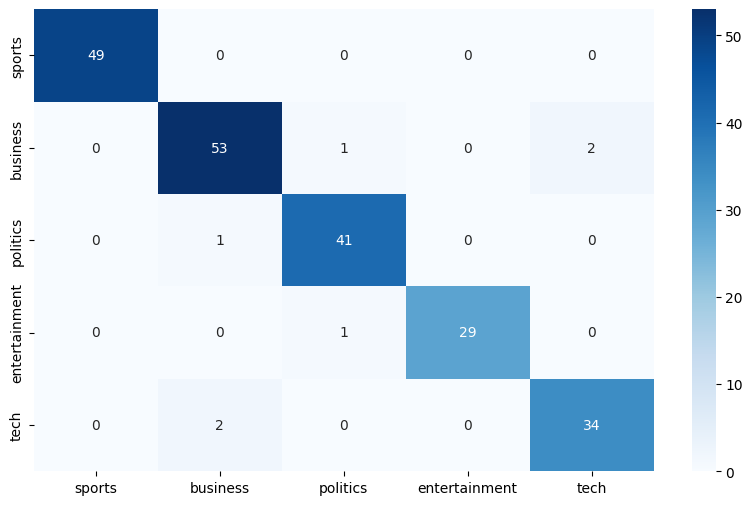

In [8]:
import matplotlib.pyplot as plt

def plt_confusion_matrix(predictions,target_values):
    cm = confusion_matrix(predictions,target_values)
    sns.heatmap(cm, fmt='d',annot=True,cmap="Blues",xticklabels=["sports","business","politics","entertainment","tech"],yticklabels=["sports","business","politics","entertainment","tech"])


plt.figure(figsize=(10,6))
plt_confusion_matrix(predictions, target_values)